# Train a JointVAE model

### Get MNIST data
Build a simple JointVAE model on MNIST

In [1]:
VAE_TRAIN = False
FIND_DIST = False
FOLDER = "dist5-celeba"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from dataloaders import get_celeba_dataloader

train_loader, test_loader = get_celeba_dataloader(path_to_data='/home/data/bvaa/CelebA')

In [ ]:
# from torchvision import datasets, transforms
# all_transforms = transforms.Compose([
#         transforms.Resize(32),
#         transforms.ToTensor()
#     ])
# train_data = datasets.CIFAR10('/home/data/bvaa/', train=True, download=True,
#                                 transform=all_transforms)

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data,target) = next(examples)

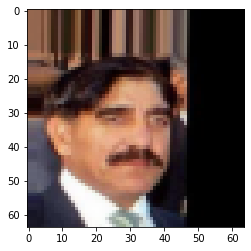

In [21]:
plt.imshow(example_data[3].permute(1,2,0).numpy())

In [22]:
target[3]

tensor(1)

### Define latent distribution of the model

### Build a model

### Train the model

In [4]:
from torch import optim

In [5]:
## Classifiers
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
#         print("x shape:", x.shape)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet152(num_classes, grayscale):
    """Constructs a ResNet-152 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 36, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=grayscale)
    return model




## Add here

In [6]:
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 2
BATCH_SIZE = 32
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False

In [90]:
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################

classifier = resnet152(NUM_CLASSES, GRAYSCALE)
classifier.to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

In [92]:
import time

from tqdm.notebook import tqdm

def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        features = F.upsample(features, (32,32), mode='bilinear', align_corners=True)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in tqdm(range(NUM_EPOCHS)):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        features = F.upsample(features, (32,32), mode='bilinear', align_corners=True)
            
        ### FORWARD AND BACK PROP
        logits, probas = classifier(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    classifier.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(classifier, train_loader, device=DEVICE),
              compute_accuracy(classifier, test_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/1250 | Cost: 0.4946
Epoch: 001/010 | Batch 0050/1250 | Cost: 0.2378
Epoch: 001/010 | Batch 0100/1250 | Cost: 0.2683
Epoch: 001/010 | Batch 0150/1250 | Cost: 0.1672
Epoch: 001/010 | Batch 0200/1250 | Cost: 0.1960
Epoch: 001/010 | Batch 0250/1250 | Cost: 0.2297
Epoch: 001/010 | Batch 0300/1250 | Cost: 0.1199
Epoch: 001/010 | Batch 0350/1250 | Cost: 0.1845
Epoch: 001/010 | Batch 0400/1250 | Cost: 0.0732
Epoch: 001/010 | Batch 0450/1250 | Cost: 0.1555
Epoch: 001/010 | Batch 0500/1250 | Cost: 0.1363
Epoch: 001/010 | Batch 0550/1250 | Cost: 0.2460
Epoch: 001/010 | Batch 0600/1250 | Cost: 0.0939
Epoch: 001/010 | Batch 0650/1250 | Cost: 0.2168
Epoch: 001/010 | Batch 0700/1250 | Cost: 0.0783
Epoch: 001/010 | Batch 0750/1250 | Cost: 0.0853
Epoch: 001/010 | Batch 0800/1250 | Cost: 0.1444
Epoch: 001/010 | Batch 0850/1250 | Cost: 0.1747
Epoch: 001/010 | Batch 0900/1250 | Cost: 0.1196
Epoch: 001/010 | Batch 0950/1250 | Cost: 0.1323
Epoch: 001/010 | Batch 1000/1250 | Cost:

Epoch: 007/010 | Batch 0600/1250 | Cost: 0.1311
Epoch: 007/010 | Batch 0650/1250 | Cost: 0.0766
Epoch: 007/010 | Batch 0700/1250 | Cost: 0.0655
Epoch: 007/010 | Batch 0750/1250 | Cost: 0.0682
Epoch: 007/010 | Batch 0800/1250 | Cost: 0.1103
Epoch: 007/010 | Batch 0850/1250 | Cost: 0.1422
Epoch: 007/010 | Batch 0900/1250 | Cost: 0.1100
Epoch: 007/010 | Batch 0950/1250 | Cost: 0.0908
Epoch: 007/010 | Batch 1000/1250 | Cost: 0.0467
Epoch: 007/010 | Batch 1050/1250 | Cost: 0.0405
Epoch: 007/010 | Batch 1100/1250 | Cost: 0.1456
Epoch: 007/010 | Batch 1150/1250 | Cost: 0.1202
Epoch: 007/010 | Batch 1200/1250 | Cost: 0.1231
Epoch: 007/010 | Train: 96.326% | Valid: 96.272%
Time elapsed: 107.71 min
Epoch: 008/010 | Batch 0000/1250 | Cost: 0.1099
Epoch: 008/010 | Batch 0050/1250 | Cost: 0.0508
Epoch: 008/010 | Batch 0100/1250 | Cost: 0.1418
Epoch: 008/010 | Batch 0150/1250 | Cost: 0.1093
Epoch: 008/010 | Batch 0200/1250 | Cost: 0.1032
Epoch: 008/010 | Batch 0250/1250 | Cost: 0.1244
Epoch: 008/010

In [93]:
torch.save(classifier.state_dict(), './models/celeba/classifier.pt')

In [7]:
classifier = resnet152(NUM_CLASSES, GRAYSCALE)
classifier.to(DEVICE)

classifier.load_state_dict(torch.load('models/celeba/classifier.pt'))
classifier.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 32,
               'disc': [10]}
latent_dim = 42

In [9]:
from celeba.models import VAE

model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64), use_cuda=True).cuda()

In [10]:
from celeba.training import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 50.0, 100000, 100.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 10.0, 100000, 100.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
    
# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity, use_cuda=True)

In [ ]:
# # Build a visualizer which will be passed to trainer to visualize progress during training
# from visualize import Visualizer

# viz = Visualizer(model)

In [11]:
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo

# trainer.train(train_loader, epochs=100, save_training_gif=('./training.gif', viz))
if VAE_TRAIN:
    trainer.train(train_loader, epochs=300)
    torch.save(model.state_dict(), 'models/celeba/model.pt')
else:
    model.load_state_dict(torch.load('models/celeba/model.pt'))
    model.eval()

In [12]:
from madry_celeba import WideResNet
classifier2 = WideResNet(depth=22, num_classes=2, widen_factor=10, dropRate=0.0)
classifier2.load_state_dict(torch.load('models/celeba/model_6.pt'))

for param in classifier2.parameters():
    param.requires_grad = False

In [13]:
for param in model.parameters():
    param.requires_grad = False
    
for param in classifier.parameters():
    param.requires_grad = False

In [14]:
from dataloaders import CelebADataset
from torchvision import transforms
train_data = CelebADataset('/home/data/bvaa/CelebA', transform=transforms.ToTensor())

## Digits

In [15]:
from tqdm.notebook import tqdm
list_index = {}
for i in tqdm(range(len(train_data))):
    index = train_data[i][1]
    if index not in list_index.keys():
        list_index[index] = [i]
    else:
        list_index[index].append(i)

In [17]:
l_sample_list = {}
def get_average_latent_space(list_index):
    for i in tqdm(list_index.keys()):
        for j in tqdm(list_index[i]):
            output, l_dist = model(train_data[j][0].unsqueeze(0).cuda())
            l_sample_x = model.reparameterize(l_dist)
            if i not in l_sample_list.keys():
                l_sample_list[i] = [l_sample_x]
            else:
                l_sample_list[i].append(l_sample_x)
        l_sample_list[i] = {'mean':torch.mean(torch.stack(l_sample_list[i]), dim=0),
                           'std':torch.std(torch.stack(l_sample_list[i]), dim=0)}
        
get_average_latent_space(list_index)

In [18]:
def added_noise(image, digit, alphax=0.2, betay=1, plot=False):
    output, l_dist = model(image.unsqueeze(0).float().cuda())
    l_sample_x = model.reparameterize(l_dist)
    alpha = torch.clamp(torch.randn(l_sample_list[digit]['std'].shape).cuda(), min=-1, max=1)
    test_sample = l_sample_list[digit]['mean'] + alpha*l_sample_list[digit]['std']
    test_sample = betay * l_sample_x + alphax * test_sample
    test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds.item())
    if plot:
        plt.imshow(test[0].permute(1, 2, 0).cpu().detach().numpy(), interpolation='none')
    return test_sample

tensor([[ 0.0210, -0.0563, -1.4115, -0.1596,  0.3797, -0.0402,  0.4315, -0.2981,
          0.0686, -0.8419,  0.0312, -0.0705, -0.2453,  1.2551,  0.0048, -0.0149,
          0.0097, -0.1375, -0.7861,  0.0914, -0.1650,  0.1057,  0.0694,  2.2860,
          0.1338,  0.0332, -0.1139,  0.6165, -0.0857,  0.0448, -1.8400, -0.1104,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.2000,  0.0000]], device='cuda:0')

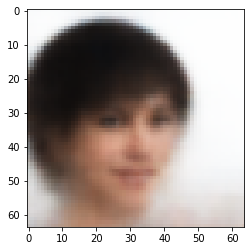

In [26]:
added_noise(example_data[40], 0, plot=True)

In [27]:
import math
def check_distribution(digit, plot=False):
    alpha = torch.clamp(torch.randn(l_sample_list[digit]['std'].shape).cuda(), min=-1, max=1)
    test_sample = l_sample_list[digit]['mean'] + alpha*l_sample_list[digit]['std']
    test = model.decode(test_sample)
#     preds = torch.argmax(classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True)))
#     print(preds.item())
    if plot:
        plt.imshow(test[0].permute(1, 2, 0).cpu().detach().numpy(), interpolation='none')
    return test_sample

tensor([[-0.0140, -0.0326,  0.5289, -0.3182, -0.0369, -0.0282,  0.0818,  0.6221,
         -0.0861,  0.2131,  0.0275,  0.1036, -0.0459,  0.2696,  0.0117,  0.0152,
         -0.0096, -0.0127, -0.7186, -0.0411, -0.0138, -0.3303, -0.0376, -0.1122,
          0.0293, -0.0505,  0.0473,  0.3085, -0.0289, -0.0849,  0.2791, -0.0223,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000]], device='cuda:0')

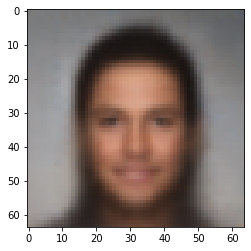

In [34]:
check_distribution(0, plot=True)

In [35]:
def digits_add(digit1, digit2, alpha=1, beta=1, plot=False):
    l_1 = check_distribution(digit1)
    l_2 = check_distribution(digit2)
    if plot:
        test = model.decode(beta*l_1+alpha*l_2)
        plt.imshow(test[0].permute(1,2,0).cpu().detach().numpy(), interpolation='none')
#         preds = classifier(F.upsample(test, (28,28), mode='bilinear', align_corners=True))
#         print(preds.dtype)
#         print(torch.argmax(preds).item())
    return torch.norm(l_1-l_2), l_1, l_2

In [36]:
def get_avg_dist(digit1, digit2, exp=10000):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    distance = []
    similarity = []
    for i in range(exp):
        dist, l1, l2 = digits_add(digit1,digit2)
        similar = cos(l1,l2)
        distance.append(dist.item())
        similarity.append(similar.item())
    a = round(sum(distance)/len(distance),5)
    b = round(sum(similarity)/len(similarity),5)
    return a,b

In [37]:
def digit_to_study(digit):
    distance = {}
    similarity = {}
    for i in tqdm(range(10)):
        distance[i], similarity[i] = get_avg_dist(digit,i)
    return distance, similarity

### Visualize

In [ ]:
# examples = enumerate(test_loader)
# batch_idx, (example_data,target) = next(examples)

In [38]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

ssim_loss = SSIM(window_size = 5)

In [39]:
use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')

# Constrained Translator
class Noise(nn.Module):
    def __init__(self, hidden_layers=[50, 100, latent_dim], latent_dim=latent_dim):
        super(Noise, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [40]:
# Constrained Cofficients
class Cofficients(nn.Module):
    def __init__(self, hidden_layers=[40, 20, 10, 1], latent_dim=latent_dim):
        super(Cofficients, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [42]:
# from skimage.metrics import structural_similarity as ssim

use_cuda = True
device = torch.device('cuda' if use_cuda else 'cpu')


def create_logits(preds, device=device):
#     print(preds)
    preds = preds.cpu()
    logits = preds
    
    sorted_ = torch.argsort(preds, dim=1, descending=True)
    first = sorted_[:,0]
    second = sorted_[:,1]
    
    p_first = preds.gather(1, first.view(-1,1))
    p_second = preds.gather(1, second.view(-1,1))
#     print(p_first.shape)
    
    means = torch.mean(torch.stack([p_first, p_second]), dim=0).squeeze(1)
#     print(means.shape)
    diff = 0.5*(p_first - p_second).squeeze(1)
#     print(diff.shape)
    j = torch.arange(logits.size(0)).long()
    
    logits[j, first] = torch.FloatTensor(means - diff)
    logits[j, second] = torch.FloatTensor(means + diff)
    
    return logits.to(device), first, second

def structural(org_image, noised_image):
    batch_size, channels, width, height = org_image.shape
    loss1 = 0
    for b_ in range(batch_size):
        ch_loss = 0
        for ch_ in range(channels):
            ch_loss += 1-ssim(org_image[b_][ch_].detach().cpu().numpy(), noised_image[b_][ch_].detach().cpu().numpy())
        loss1 += ch_loss/channels
    return loss1
            
class T_Loss(nn.Module):
    def __init__(self, classifier=classifier, classifier2=classifier2, decoder=model.decode,
                 latent_dim=latent_dim, l_samples=l_sample_list,
                 classes=2):
        super(T_Loss, self).__init__()
        self.decoder = decoder
        self.classifier = classifier
#         self.means = means
#         self.stds = stds
        self.l_samples = l_samples
        self.classes = classes
        self.latent_dim = latent_dim
        self.classifier2 = classifier2
        
        
    def forward(self, coffs, noises, org_x, targets, alpha=0.6, beta=1, train=True):
        
        org_image = self.decoder(org_x)
        _,preds = self.classifier(F.upsample(org_image, (32,32), mode='bilinear', align_corners=True))
#         else:
#             preds = self.classifier(F.upsample(org_image, (32,32), mode='bilinear', align_corners=True))
        
        alt_target, first, second = create_logits(preds)
        
        means = []
        stds = []
        
        for key in second:
            means.append(self.l_samples[key.item()]['mean'])
            stds.append(self.l_samples[key.item()]['std'])
        
        means = torch.stack(means)
        stds = torch.stack(stds)
#         print(noises.shape)
#         print(stds.shape)
        noised_latent = means.squeeze(1) + torch.clamp(noises, min=-5, max=5) * stds.squeeze(1)
        
        noised_latent = torch.clamp(coffs, min=-3, max=3) * noised_latent
#         noise_latent = F.normalize(coffs) * noise_latent
        
        noised_sample = beta * org_x + alpha * noised_latent
        
        noised_image = self.decoder(noised_sample)
        if train:
            _,preds = self.classifier(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
#         loss = 0.8*loss2 + 20*loss3
#         loss = loss2 + 20*loss3
            loss1 = ssim_loss(org_image, noised_image)
#             print(preds.shape)
#             print(alt_target.shape)
#             alt_target.requires_grad = True
            loss2 = nn.BCELoss(reduction='sum')(preds, alt_target.float().detach())

            loss3 = torch.norm(org_image-noised_image, p=2)  

            loss = 500*(1-loss1) + loss2 + 30*loss3  
        else:
            preds = self.classifier2(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
            loss = 0

  
        
        out_labels = preds.argmax(dim=1, keepdim=True)
#         print(out_labels)
#         print(torch.empty(out_labels.shape).fill_(target_label))
#         print(preds)
#         correct = out_labels.eq(torch.Tensor([target_label]*out_labels.shape[0]).to(device)).sum()
#         print(out_labels.shape)
#         print((out_labels.squeeze(1)==targets.cuda()).sum())
        correct = (out_labels.squeeze(1)==targets.cuda()).sum()
#         print(out_labels.shape)
#         print(correct)
#         print(torch.Tensor([target_label]*out_labels.shape[0]))
#         print(out_labels)
        return loss, correct.item()

In [43]:
# alt_target = 5
noise = Noise().to(device)
cofficient = Cofficients().to(device)

for param in noise.parameters():
    param.requires_grad=True
    
for param in cofficient.parameters():
    param.requires_grad=True

In [44]:
tloss = T_Loss().to(device)
tloss.eval()

T_Loss(
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
# count_digit = 0
# for i in range(len(train_data)):
#     if train_data[i][1]==5:
#         count_digit += 1
# print(count_digit)

In [45]:
from tqdm.notebook import tqdm
attack_log_interval = 1

noise.train()
cofficient.train()

optimizer1 = optim.Adam(noise.parameters(), lr=1e-4)
# optimizer1 = torch.optim.SGD(noise.parameters(), lr=1e-4, momentum=0.9)

# optimizer2 = torch.optim.SGD(cofficient.parameters(), lr=1e-4, momentum=0.9)
optimizer2 = optim.Adam(cofficient.parameters(), lr=1e-4)


# scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer1, base_lr=1e-7, max_lr=0.1)
# scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer2, base_lr=1e-7, max_lr=0.1)

for epoch in tqdm(range(150)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data = data.float()
        data = torch.Tensor(data).float().to(device)
#         print(data.type)
        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)
        
        n = noise(l_sample)
        c = cofficient(l_sample)

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        loss, correct = tloss(c, n, l_sample, target, alpha=0.2, beta=0.8)

        loss.backward()
        
        optimizer1.step()
        optimizer2.step()

#         scheduler1.step()
#         scheduler2.step()

        epoch_loss += loss.item()
    
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch+1, epoch_loss/batch_idx, epoch_correct))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



Train Epoch: 1	Loss: 2259.374817	Correct: 114900



Train Epoch: 2	Loss: 2011.388306	Correct: 115298



Train Epoch: 3	Loss: 1956.970706	Correct: 115199



Train Epoch: 4	Loss: 1923.418570	Correct: 115147



Train Epoch: 5	Loss: 1884.244632	Correct: 115003



Train Epoch: 6	Loss: 1862.888648	Correct: 115041



Train Epoch: 7	Loss: 1845.556514	Correct: 114963


KeyboardInterrupt: 

In [46]:
torch.save(noise.state_dict(), 'models/{}/noise.pt'.format(FOLDER))
torch.save(cofficient.state_dict(), 'models/{}/coff.pt'.format(FOLDER))

In [31]:
noise = torch.load('models/{}/noise.pt'.format(FOLDER))
cofficient = torch.load('models/{}/coff.pt'.format(FOLDER))

In [102]:
tloss = T_Loss(classifier=classifier2).to(device)
tloss.eval()

T_Loss(
  (classifier): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1): NetworkBlock(
      (layer): Sequential(
        (0): BasicBlock(
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (poolpadShortcut): Sequential(
            (0): AvgPool2d(kernel_size=1, stride=1, padding=0)
            (1): ChannelPadding()
          )
        )
        (1): BasicBlock(
          (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
     

In [47]:
noise.eval()
cofficient.eval()
total_correct = 0
total_test = 0
with torch.set_grad_enabled(False):
    for batch_idx, (data, target) in enumerate(test_loader):
        total_test += data.shape[0]
        data = data.float()
        data = torch.Tensor(data).float().to(device)

        _, l_dist = model(data)
        l_sample = model.reparameterize(l_dist)

        noise_ = noise(l_sample)
        coff_ = cofficient(l_sample)

        loss, correct = tloss(coff_, noise_, l_sample, target, 1, 0, train=False)
        total_correct += correct
    #     print(correct)
    #         loss.backward()
    #         optimizer.step()
    #         print(correct)
    #         epoch_loss += loss.item()


    #     if (epoch+1) % attack_log_interval == 0:
    #         print('Train Epoch: \tCorrect: {}'.format(
    #             epoch, epoch_correct))
print(total_correct)
print("Accuracy: ", 100*(total_correct/total_test))

22298
Accuracy:  55.745


In [48]:
def check(i, alpha=0.6, beta=1):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)

    _,org_preds = classifier(F.upsample(model.decode(l_sample), (32,32), mode='bilinear', align_corners=True))
#     print("original: ", torch.argmax(org_preds, dim=1))

    noises = noise(l_sample)
    coffs = cofficient(l_sample)

    d = torch.argsort(org_preds, dim=1, descending=True)
#     print(d)

    noised_latent = l_sample_list[d[0,1].item()]['mean'].squeeze(1) + torch.clamp(noises, min=-5, max=5) * l_sample_list[d[0,1].item()]['std'].squeeze(1)
    
    noised_latent = torch.clamp(coffs, min=-3, max=3) * noised_latent
#     noised_latent = F.normalize(coffs) * noised_latent

    noised_sample = beta * l_sample + alpha * noised_latent

    noised_image = model.decode(noised_sample)

    _,fake_preds = classifier(F.upsample(noised_image, (32,32), mode='bilinear', align_corners=True))
#     print("noised: ", torch.argmax(fake_preds, dim=1))
#     print(example_data[i].permute(1,2,0).shape)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i].permute(1,2,0).detach().cpu().numpy())
    plt.title("org:{}".format(torch.argmax(org_preds, dim=1)))
    plt.subplot(1,2,2)
    plt.imshow(noised_image[0].permute(1,2,0).detach().cpu().numpy())
    plt.title("fake:{}".format(torch.argmax(fake_preds, dim=1)))

In [49]:
examples = enumerate(test_loader)

In [50]:
batch_idx, (example_data,target) = next(examples)

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


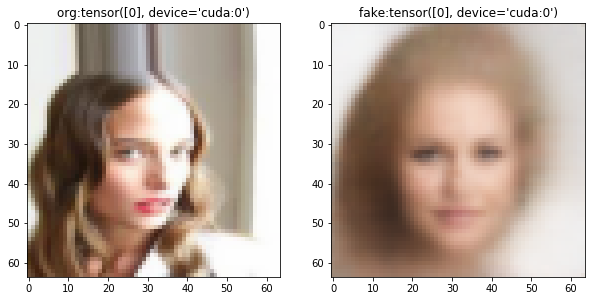

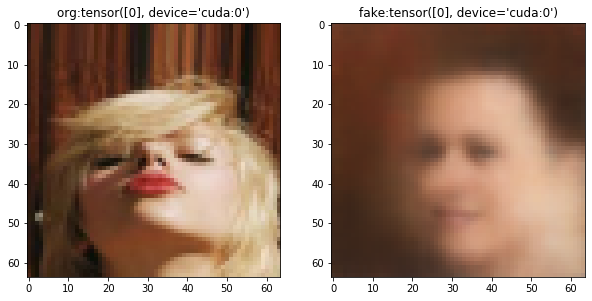

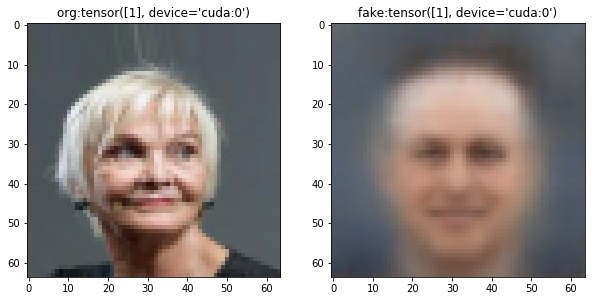

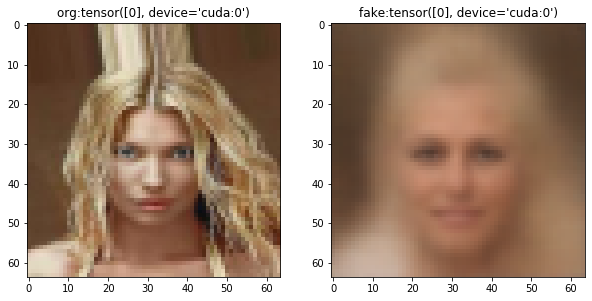

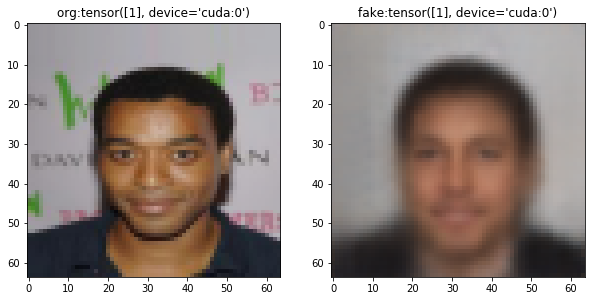

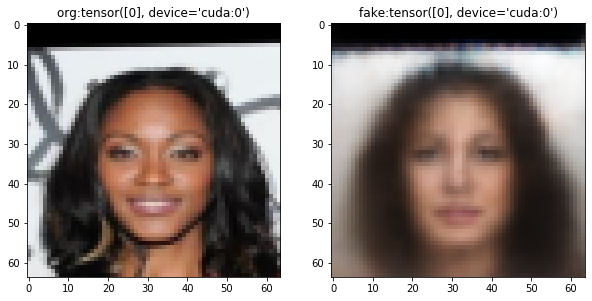

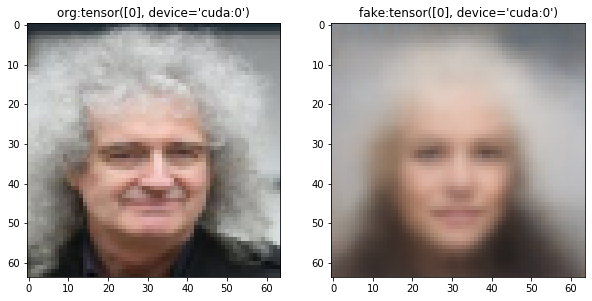

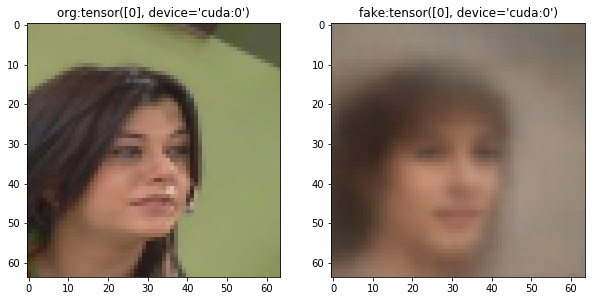

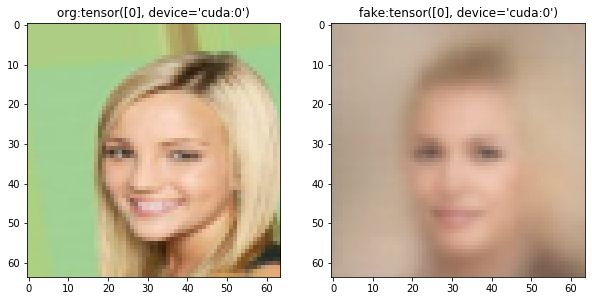

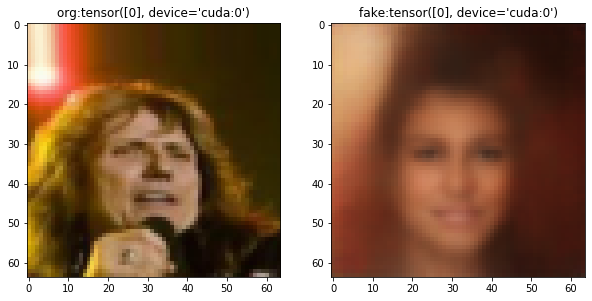

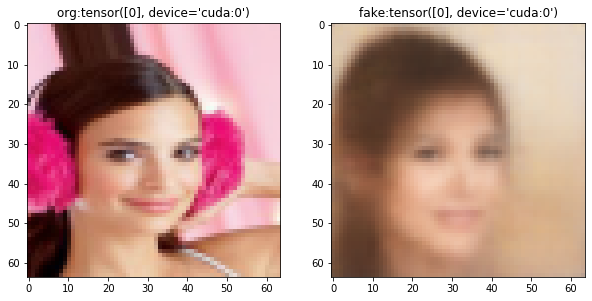

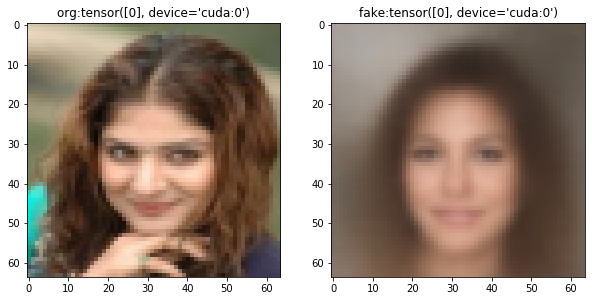

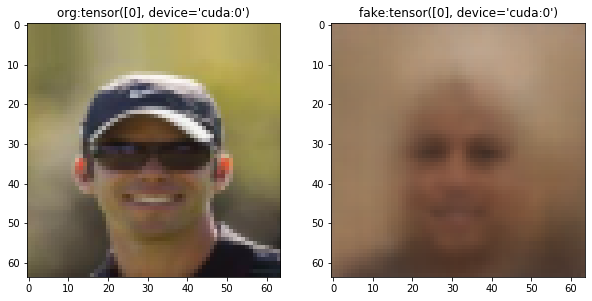

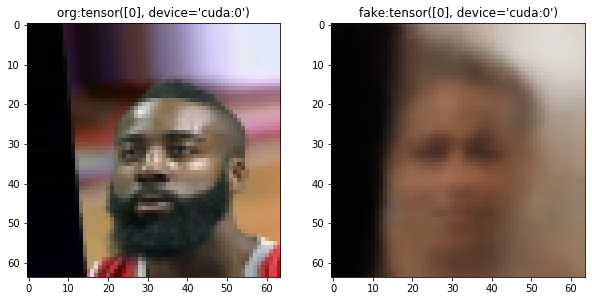

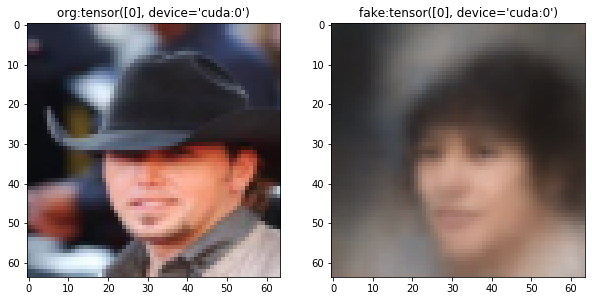

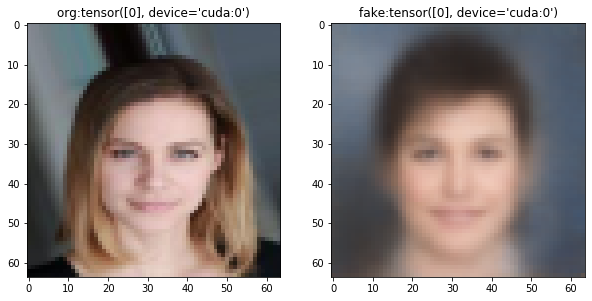

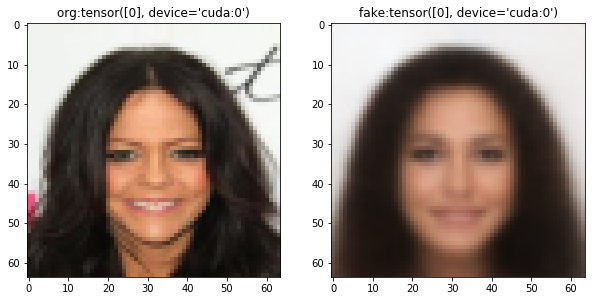

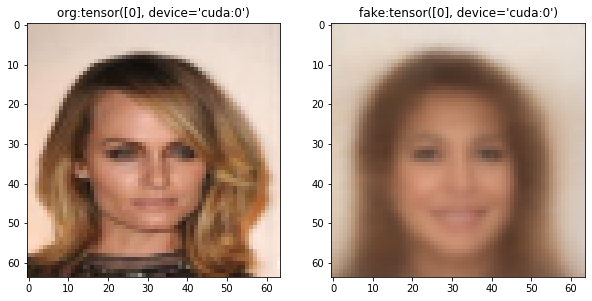

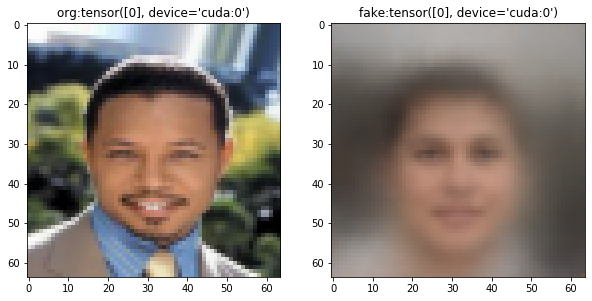

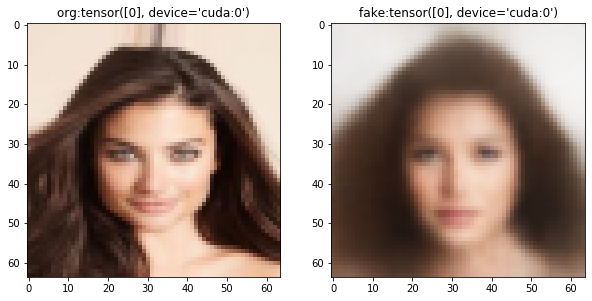

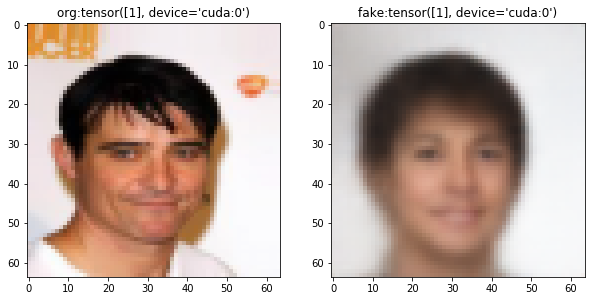

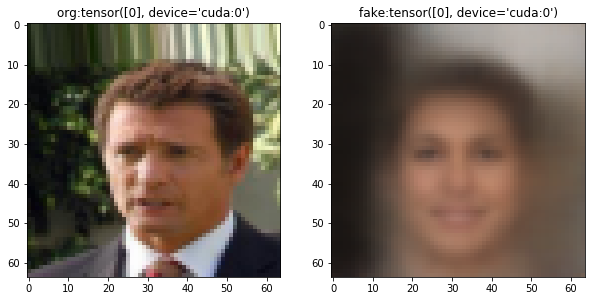

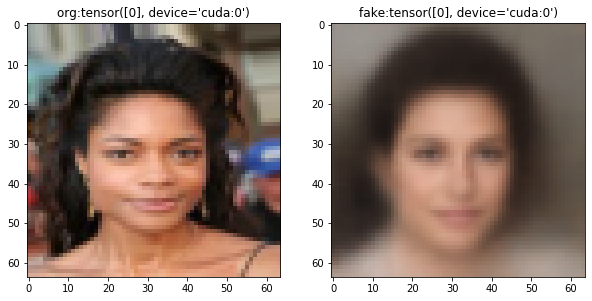

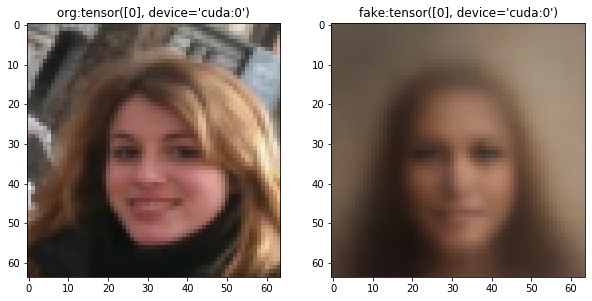

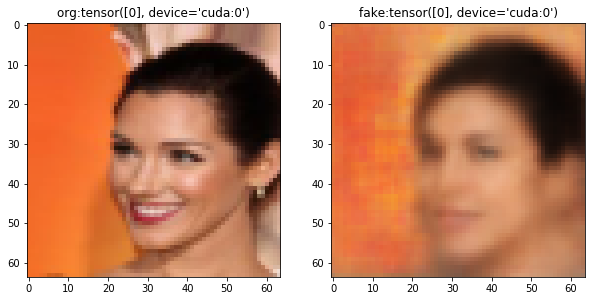

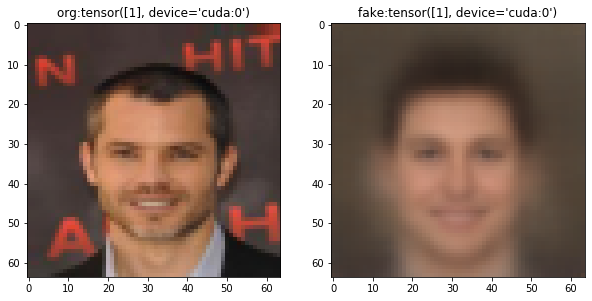

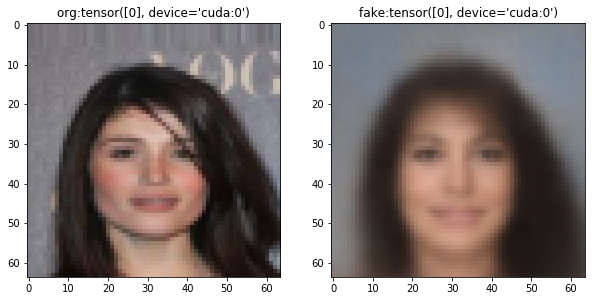

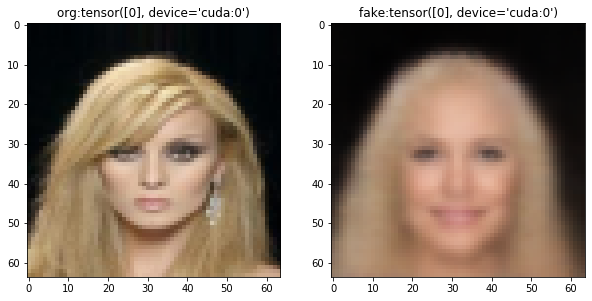

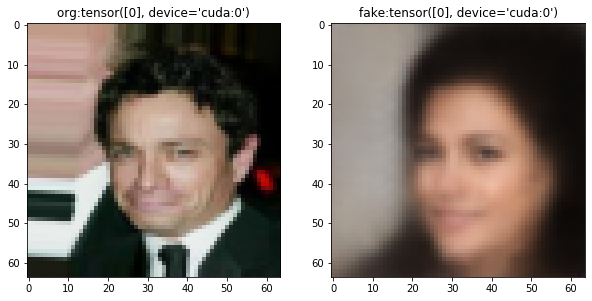

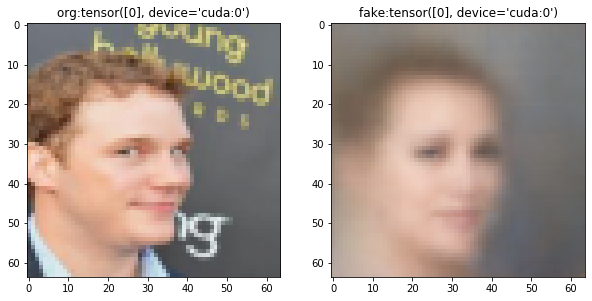

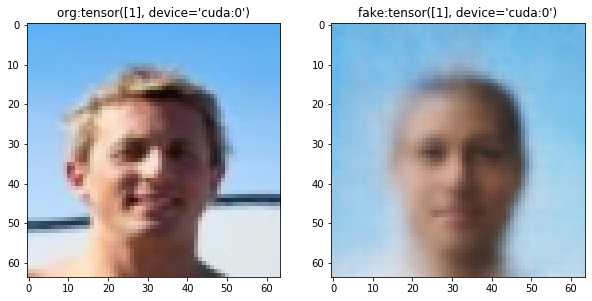

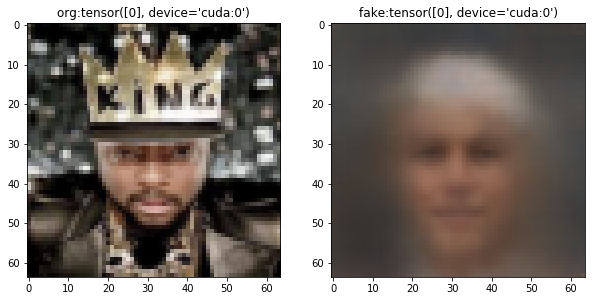

In [51]:
for i in range(32):
    check(i,0.2,0.8)

In [ ]:
def test(i, means=l_mean_tensor, stds=l_std_tensor, latent_dim=latent_dim, classes=len(train_data.classes)):
    _, l_dist = model(example_data[i].unsqueeze_(0).to(device))
    l_sample = model.reparameterize(l_dist)
    noises = noise(l_sample)
    coffs = cofficient(l_sample)
#     print(coffs.shape)
#     print(noises.shape)
    noised_latent = means + noises.reshape(noises.shape[0], classes, latent_dim)*stds
    noised_latent = coffs[:,:,None]*noised_latent
#     print(noised_latent.shape)
#     print(l_sample.shape)
#     print(torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1).shape)
#     noised_latent = l_sample + 2e-1*torch.transpose(coff[:,None].cuda()*avg_latent.T, 1, 2).sum(1)
#     print(noised_latent.shape)
#     print(noised_sample)
#     print(l_sample)
#     noised_sample = 1 * ((l_sample - l_sample.min())/(l_sample.max() - l_sample.min())) + 1e-2 * ((noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min()))
#     noised_sample = 1 * l_sample + 2e-2 * noised_sample
#     noised_sample = l_sample + 1e-7 * noised_sample
    final = model.decode(l_sample+1e-12*noised_latent.sum(dim=1))
#     print(final.shape)
    pred_org = torch.argmax(classifier(F.upsample(example_data[i,:,:,:].unsqueeze(0).cuda(), (28,28), mode='bilinear', align_corners=True)))
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)), dim=1)
#     print(pred)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}, {}".format(pred_org.item(), pred.item()))

In [ ]:
for i in range(64):
    test(i)

In [ ]:
torch.transpose(torch.clamp(coff[:,None].cuda(), min=-0.8, max=0.3)*self.avg_latent.T, 1, 2).sum(1)